# 04 - Spline Effects Model

This notebook explores nonlinear effects of age and mileage using B-splines,
while retaining partial pooling (random intercepts) on categorical predictors.

**Model comparison:**
| Model | Continuous | Categoricals |
|-------|------------|---------------|
| Hierarchical | Linear age + random slope by gen | Random intercepts |
| Spline | `bs(age)` + `bs(mileage_scaled)` | Random intercepts |

In [1]:
import logging
from pathlib import Path

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from price_analysis.data.cleaning import prepare_model_data
from price_analysis.models import (
    build_model,
    build_spline_model,
    compare_models_loo,
    compare_residual_stats,
    fit_model,
    fit_spline_model,
    get_residuals,
    plot_residual_diagnostics,
    plot_spline_effects_grid,
)
from price_analysis.models.hierarchical import check_diagnostics

logging.basicConfig(level=logging.INFO)
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [2]:
DATA_DIR = Path("../data")
PROCESSED_PATH = DATA_DIR / "processed" / "cleaned_listings.parquet"

## Load and Prepare Data

In [3]:
df_cleaned = pd.read_parquet(PROCESSED_PATH)
df = prepare_model_data(df_cleaned, group_trims=True, group_trans=True)

MILEAGE_MEAN, MILEAGE_STD = df_cleaned["mileage"].mean(), df_cleaned["mileage"].std()

print(f"Model data: {len(df)} listings")
print(f"Age range: {df['age'].min()} - {df['age'].max()} years")
print(
    f"Mileage range (scaled): {df['mileage_scaled'].min():.2f} - {df['mileage_scaled'].max():.2f}"
)

INFO:price_analysis.data.cleaning:Grouped trims into tiers: {'sport': 392, 'base': 360, 'turbo': 272, 'gt': 148, 'gts': 100, 'rs': 88}
INFO:price_analysis.data.cleaning:Grouped transmissions into types: {'manual': 790, 'pdk': 476, 'auto': 94}
INFO:price_analysis.data.cleaning:Model-ready dataset: 1360 listings (from 1615 cleaned)


Model data: 1360 listings
Age range: 0.0 - 26.0 years
Mileage range (scaled): -1.05 - 5.03


## Build Spline Model

In [4]:
AGE_DF = 4  # Degrees of freedom for age spline
MILEAGE_DF = 4  # Degrees of freedom for mileage spline
INCLUDE_SALE_YEAR = False  # All 2025 listings
TARGET_ACCEPT = 0.975

In [5]:
spline_model = build_spline_model(
    df,
    age_df=AGE_DF,
    mileage_df=MILEAGE_DF,
    include_sale_year=INCLUDE_SALE_YEAR,
)
print(spline_model)

INFO:price_analysis.models.spline:Spline model formula: log_price ~ 1 + bs(age, df=4) + bs(mileage_scaled, df=4) + is_low_mileage + (1 | generation) + (1 | trim_tier) + (1 | trans_type) + (1 | body_style)
INFO:price_analysis.models.spline:Built spline model with 1360 observations


       Formula: log_price ~ 1 + bs(age, df=4) + bs(mileage_scaled, df=4) + is_low_mileage + (1 | generation) + (1 | trim_tier) + (1 | trans_type) + (1 | body_style)
        Family: gaussian
          Link: mu = identity
  Observations: 1360
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 11.3507, sigma: 6.9573)
            bs(age, df=4) ~ Normal(mu: [0. 0. 0. 0.], sigma: [ 9.9863 11.816   8.5029  7.417 ])
            bs(mileage_scaled, df=4) ~ Normal(mu: [0. 0. 0. 0.], sigma: [ 8.2372 11.7708 18.7278 42.4866])
            is_low_mileage ~ Normal(mu: 0.0, sigma: 4.7327)
        
        Group-level effects
            1|generation ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.5))
            1|trim_tier ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.7))
            1|trans_type ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.3))
            1|body_style ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.3))
        
        Auxiliary parameters
     

## Fit Spline Model

In [6]:
%%time
idata_spline = fit_spline_model(
    spline_model,
    draws=1000,
    tune=1000,
    chains=8,
    cores=8,
    target_accept=TARGET_ACCEPT,
)

INFO:price_analysis.models.spline:Fitting spline model: 2000 draws, 1000 tune, 8 chains
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 4 jobs)
INFO:pymc.sampling.mcmc:Multiprocess sampling (8 chains in 4 jobs)
NUTS: [sigma, Intercept, bs(age, df=4), bs(mileage_scaled, df=4), is_low_mileage, 1|generation_sigma, 1|generation_offset, 1|trim_tier_sigma, 1|trim_tier_offset, 1|trans_type_sigma, 1|trans_type_offset, 1|body_style_sigma, 1|body_style_offset]
INFO:pymc.sampling.mcmc:NUTS: [sigma, Intercept, bs(age, df=4), bs(mileage_scaled, df=4), is_low_mileage, 1|generation_sigma, 1|generation_offset, 1|trim_tier_sigma, 1|trim_tier_offset, 1|trans_type_sigma, 1|trans_type_offset, 1|body_style_sigma, 1|body_style_offset]


Output()

Sampling 8 chains for 1_000 tune and 2_000 draw iterations (8_000 + 16_000 draws total) took 300 seconds.
INFO:pymc.sampling.mcmc:Sampling 8 chains for 1_000 tune and 2_000 draw iterations (8_000 + 16_000 draws total) took 300 seconds.


CPU times: user 18.4 s, sys: 1.39 s, total: 19.8 s
Wall time: 5min 8s


## Diagnostics

In [7]:
diagnostics = check_diagnostics(idata_spline)
print(f"Converged: {diagnostics['converged']}")
print(f"Divergences: {diagnostics['n_divergences']}")
print(f"Max R-hat: {diagnostics['rhat_max']:.3f}")
print(f"Min ESS (bulk): {diagnostics['ess_bulk_min']:.0f}")
if diagnostics["issues"]:
    print(f"Issues: {diagnostics['issues']}")

Converged: True
Divergences: 0
Max R-hat: 1.000
Min ESS (bulk): 4646


/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_11925/1358940689.py:3: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


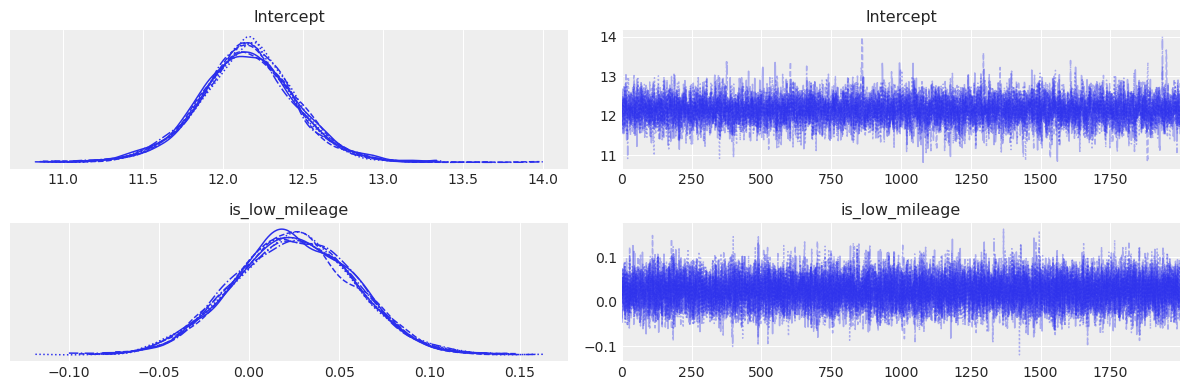

In [8]:
var_names = ["Intercept", "is_low_mileage"]
az.plot_trace(idata_spline, var_names=var_names)
plt.tight_layout()

## Visualize Spline Effects

These plots show the estimated nonlinear relationship between age/mileage and log(price),
holding other variables at their median/mode values.

/Users/flatljan/personal/price-trend-analysis/src/price_analysis/models/spline.py:284: UserWarning: The figure layout has changed to tight
  Args:


Text(0.5, 1.02, 'Spline Effects on log(price)')

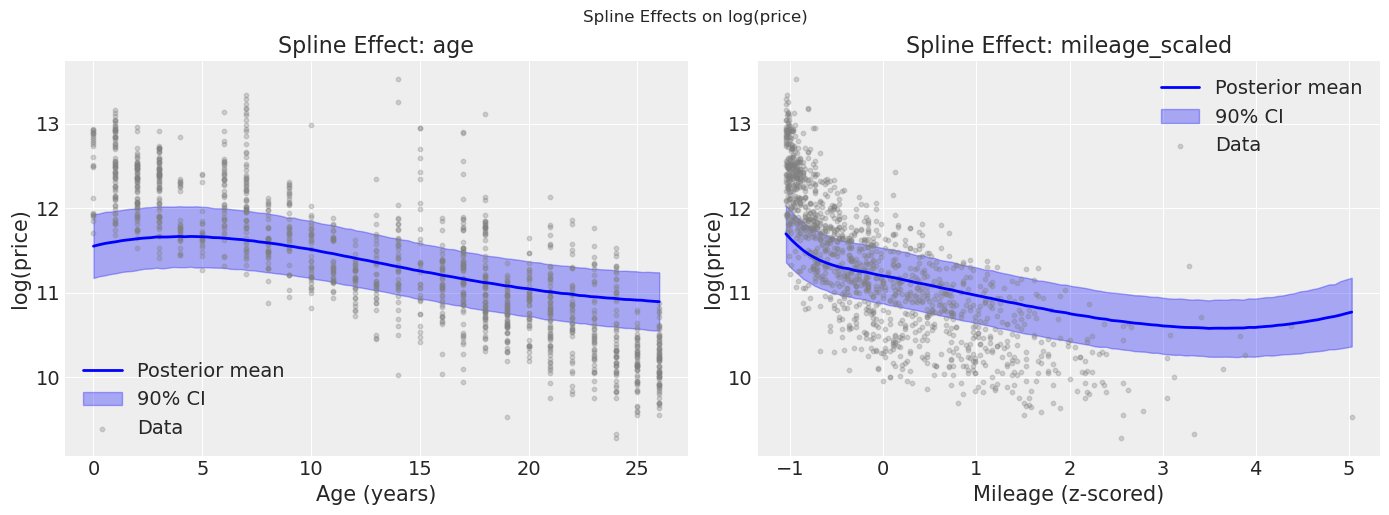

In [9]:
fig = plot_spline_effects_grid(spline_model, idata_spline, df)
fig.suptitle("Spline Effects on log(price)", y=1.02)

## Fit Hierarchical Model for Comparison

In [10]:
hierarchical_model = build_model(
    df,
    include_sale_year=INCLUDE_SALE_YEAR,
    include_generation_slope=True,
    use_trim_tier=True,
    use_trans_type=True,
)
print(hierarchical_model)

INFO:price_analysis.models.hierarchical:Model formula: log_price ~ 1 + age + mileage_scaled + is_low_mileage + (1 + age | generation) + (1 | trim_tier) + (1 | trans_type) + (1 | body_style)
INFO:price_analysis.models.hierarchical:Built model with 1360 observations


       Formula: log_price ~ 1 + age + mileage_scaled + is_low_mileage + (1 + age | generation) + (1 | trim_tier) + (1 | trans_type) + (1 | body_style)
        Family: gaussian
          Link: mu = identity
  Observations: 1360
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 11.3507, sigma: 2.0573)
            age ~ <function _truncated_normal_upper at 0x13933c680>(sigma: 0.05)
            mileage_scaled ~ <function _truncated_normal_upper at 0x13933c680>(sigma: 0.3)
            is_low_mileage ~ <function _truncated_normal_lower at 0x13933c720>(sigma: 0.2)
        
        Group-level effects
            1|generation ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.5))
            age|generation ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.1))
            1|trim_tier ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.7))
            1|trans_type ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.3))
            1|body_style ~ Normal(mu: 0.0, sigma: HalfN

In [ ]:
%%time
idata_hierarchical = fit_model(
    hierarchical_model,
    draws=1000,
    tune=1000,
    chains=8,
    cores=8,
    target_accept=TARGET_ACCEPT,
)

INFO:price_analysis.models.hierarchical:Fitting model: 1000 draws, 1000 tune, 8 chains, target_accept=0.975
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
INFO:pymc.sampling.mcmc:Multiprocess sampling (8 chains in 8 jobs)
NUTS: [sigma, Intercept, age, mileage_scaled, is_low_mileage, 1|generation_sigma, 1|generation_offset, age|generation_sigma, age|generation_offset, 1|trim_tier_sigma, 1|trim_tier_offset, 1|trans_type_sigma, 1|trans_type_offset, 1|body_style_sigma, 1|body_style_offset]
INFO:pymc.sampling.mcmc:NUTS: [sigma, Intercept, age, mileage_scaled, is_low_mileage, 1|generation_sigma, 1|generation_offset, age|generation_sigma, age|generation_offset, 1|trim_tier_sigma, 1|trim_tier_offset, 1|trans_type_sigma, 1|trans_type_offset, 1|body_style_sigma, 1|body_style_offset]


Output()

## LOO-CV Model Comparison

Compare models using Leave-One-Out Cross-Validation (PSIS-LOO).
Higher ELPD = better out-of-sample predictive performance.

In [ ]:
comparison = compare_models_loo(
    {
        "hierarchical (linear + random slopes)": idata_hierarchical,
        "spline (bs age/mileage + random intercepts)": idata_spline,
    }
)
display(comparison)

In [ ]:
az.plot_compare(comparison)
plt.title("Model Comparison (LOO-CV)")

## Residual Comparison

Compare residual patterns to see if the spline model better captures
nonlinear relationships that the linear model misses.

In [ ]:
residuals_hierarchical = get_residuals(hierarchical_model, idata_hierarchical, df)
residuals_spline = get_residuals(spline_model, idata_spline, df)

residuals_dict = {
    "Hierarchical": residuals_hierarchical,
    "Spline": residuals_spline,
}

In [ ]:
stats_df = compare_residual_stats(residuals_dict)
display(stats_df.round(4))

In [ ]:
fig = plot_residual_diagnostics(residuals_dict)

## Degrees of Freedom Sensitivity

Quick check: does the number of spline basis functions matter much?

In [ ]:
# Compare df=3 vs df=5 (optional - can be slow)
# Uncomment to run sensitivity analysis

# df_sensitivity = {}
# for df_val in [3, 5]:
#     model = build_spline_model(df, age_df=df_val, mileage_df=df_val, include_sale_year=False)
#     idata = fit_spline_model(model, draws=1000, tune=500, chains=4)
#     df_sensitivity[f"df={df_val}"] = idata

# df_sensitivity["df=4"] = idata_spline
# sensitivity_comparison = compare_models_loo(df_sensitivity)
# display(sensitivity_comparison)

## Summary

**Key findings:**

1. **Spline effects**: [interpret the shape of age/mileage curves]

2. **Model comparison**: [ELPD difference and interpretation]

3. **Residuals**: [any patterns resolved by splines?]

**Recommendations:**

- [which model to prefer for inference vs prediction?]
- [any follow-up analyses needed?]